In [1]:
import string
import os
from os.path import join
import glob
import json

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from scipy.stats import spearmanr



from naturalcogsci.helpers import get_project_root

PROJECT_ROOT = get_project_root()

mpl.rcParams.update(mpl.rc_params_from_file(join(PROJECT_ROOT, ".matplotlibrc")))

FIGWIDTH = mpl.rcParams["figure.figsize"][0]
CMAP = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
CATEGORYTRIALS = 120
REWARDTRIALS = 60
SMALLER_SIZE = 6
BIGGER_SIZE = 12


with open(join(PROJECT_ROOT, "data", "model_plot_params.json")) as f:
    plot_params = json.load(f)
plot_params = {k.replace("/", "_"): v for k, v in plot_params.items()}
main_feature_names = list(plot_params.keys())

In [2]:
dfs = glob.glob(
    join(
        PROJECT_ROOT,
        "data",
        "learner_behavioural",
        "category_learning",
        "*_l2_original.csv",
    )
)
dfs = [pd.read_csv(x) for x in dfs]
model_df = pd.concat(dfs)
model_df["nll"] = -np.where(
    model_df.choice == 1, np.log(model_df.prob),np.log(1 - model_df.prob)
)
model_df = model_df[model_df.features.isin(main_feature_names)]
model_df["return"] = np.where(np.round(model_df.prob) == model_df.true_category_binary, 1, 0)
chance_level = -model_df.participant.nunique() * CATEGORYTRIALS * np.log(0.5)
model_df = model_df.groupby("features").agg({"nll": "sum", "return": "mean"}).reset_index()
model_df = model_df.sort_values(by="nll", ascending=True).reset_index(drop=True)
model_df["color"] = model_df["features"].apply(lambda x: plot_params[x]["colour"])
model_df["feature_key"] = model_df["features"]
model_df["alignment"] = model_df["features"].apply(lambda x: plot_params[x]["alignment"])
model_df["features"] = model_df["features"].apply(lambda x: plot_params[x]["name"])
model_df["nll"] = 1 - model_df.nll/chance_level
model_df.loc[model_df.nll==1]["nll"] = 0
category_model_df = model_df

In [3]:
dfs = glob.glob(
    join(
        PROJECT_ROOT,
        "data",
        "learner_behavioural",
        "reward_learning",
        "*_l2_original.csv",
    )
)
dfs = [pd.read_csv(x) for x in dfs]
model_df = pd.concat(dfs)
model_df = model_df[model_df.features.isin(main_feature_names)]
model_df["prob"] = np.where(model_df.prob == 1, 0.99999, model_df.prob)
model_df["nll"] = -np.where(
    model_df.choice == 1, np.log(model_df.prob), np.log(1 - model_df.prob)
)
chance_level = -model_df.participant.nunique() * REWARDTRIALS * np.log(0.5)
model_df["model_choice"] = np.where(model_df.right_value > model_df.left_value, 1,0)
model_df["best_side"] = np.where(model_df.right_reward > model_df.left_reward, 1, 0)
model_df["return"] = np.where(model_df.model_choice == model_df.best_side,1,0)
model_df = model_df.groupby("features").agg({"nll": "sum", "return": "mean"}).reset_index()
model_df = model_df.sort_values(by="nll", ascending=True).reset_index(drop=True)
model_df["color"] = model_df["features"].apply(lambda x: plot_params[x]["colour"])
model_df["alignment"] = model_df["features"].apply(lambda x: plot_params[x]["alignment"])
model_df["feature_key"] = model_df["features"]
model_df["features"] = model_df["features"].apply(lambda x: plot_params[x]["name"])
model_df["nll"] = 1 - model_df.nll/chance_level
reward_model_df = model_df

/var/folders/2t/zlktsbp913sc2d_5zx40s3rh0000gn/T/ipykernel_38570/928239537.py:29: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.scatterplot(
/var/folders/2t/zlktsbp913sc2d_5zx40s3rh0000gn/T/ipykernel_38570/928239537.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ax0_df["model_size"] = pd.to_numeric(ax0_df["model_size"], errors='coerce')
/var/folders/2t/zlktsbp913sc2d_5zx40s3rh0000gn/T/ipykernel_38570/928239537.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

Task Accuracy vs NLL correlation:
Spearman rho: 0.725
p-value: 2.828e-15

Model Size vs NLL correlation:
Spearman rho: 0.476
p-value: 9.118e-06

Training Data Size vs NLL correlation:
Spearman rho: 0.521
p-value: 8.664e-07

Class Separation vs NLL correlation:
Spearman rho: 0.291
p-value: 9.216e-03

CKA Similarity vs NLL correlation:
Spearman rho: 0.665
p-value: 5.232e-12

Intrinsic Dimensionality vs NLL correlation:
Spearman rho: -0.322
p-value: 3.842e-03


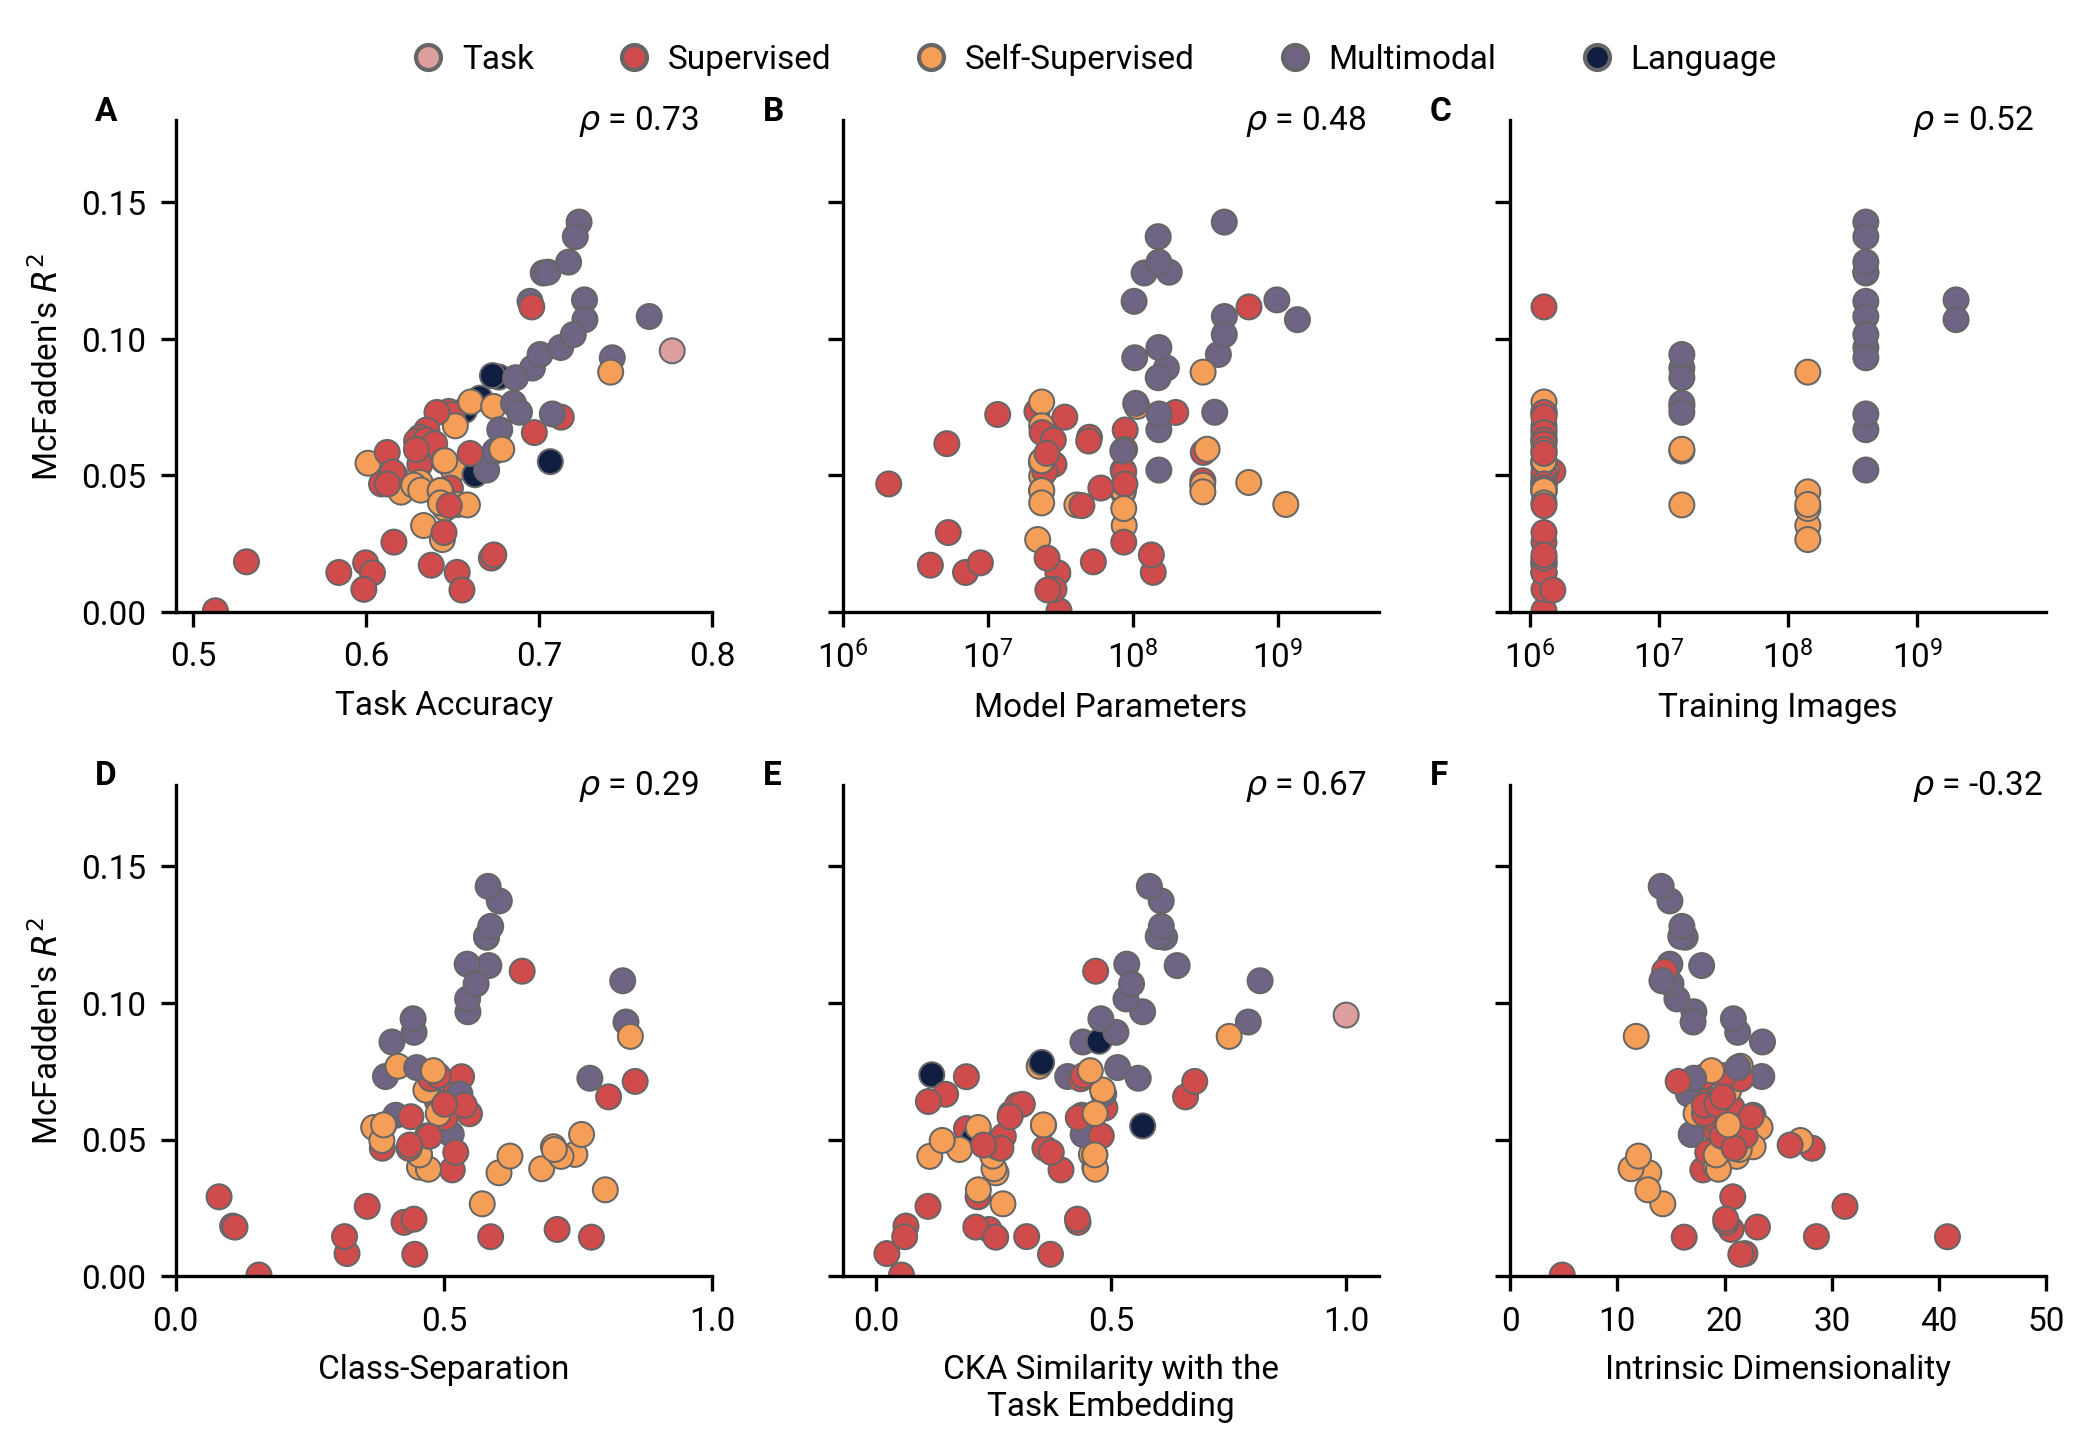

In [4]:
fig, axs = plt.subplots(2,3, figsize=(FIGWIDTH, 2*FIGWIDTH/3),sharey=True)
axs[1,0].set_ylabel("Negative Log Likelihood")

merged_df = pd.merge(
    reward_model_df[["features", "color", "nll", "return","feature_key"]],
    category_model_df[["features", "color", "nll", "return","feature_key"]],
    on=["features", "color", "feature_key"],
    suffixes=("_reward", "_category"),
)

merged_df["nll"] = (merged_df["nll_reward"] + merged_df["nll_category"])/2
merged_df["return"] = (merged_df["return_reward"] + merged_df["return_category"])/2
merged_df.drop(["return_reward", "return_category"], axis=1, inplace=True)
merged_df.drop(["nll_reward", "nll_category"], axis=1, inplace=True)
merged_df["model_size"] = model_df["feature_key"].apply(
    lambda x: plot_params[x]["size"]
)
merged_df["zero_shot"] = model_df["feature_key"].apply(
    lambda x: plot_params[x]["zero-shot"]
)
merged_df["probing"] = model_df["feature_key"].apply(
    lambda x: plot_params[x]["probing"]
)

merged_df["training_data"] = model_df["feature_key"].apply(
    lambda x: plot_params[x]["data-size"]
)

sns.scatterplot(
    data=merged_df,
    x="return",
    y="nll",
    ax=axs[0,0],
    hue="color",
    edgecolor=CMAP[-1],
    hue_order=[
        "task",
        "supervised",
        "self-supervised",
        "multimodal",
        "text",
    ],
    palette=CMAP[:-1],
    legend=False,
)
axs[0,0].set_xlabel("Task Accuracy")
axs[0,0].set_ylabel("")
tau, p_value = spearmanr(merged_df["return"], merged_df["nll"])
print("Task Accuracy vs NLL correlation:")
print(f"Spearman rho: {tau:.3f}")
print(f"p-value: {p_value:.3e}")
axs[0,0].text(0.75, 0.98, r"$\rho$ = {:.2f}".format(tau), transform=axs[0,0].transAxes)

axs[0,0].set_ylabel("Negative Log Likelihood")

ax0_df = merged_df[
    merged_df["color"].isin(
        ["supervised", "self-supervised", "multimodal"]
    )
]
ax0_df["model_size"] = pd.to_numeric(ax0_df["model_size"], errors='coerce')

ax0_df.model_size = ax0_df.model_size * 1e6

sns.scatterplot(
    data=ax0_df,
    x="model_size",
    y="nll",
    ax=axs[0,1],
    hue="color",
    hue_order=["supervised", "self-supervised", "multimodal"],
    legend=False,
    palette=CMAP[1:4],
    edgecolor=CMAP[-1],
)
axs[0,1].set_xlabel("Model Parameters")
axs[0,1].set_ylabel("")
axs[0,1].set_xscale("log")
axs[0,1].minorticks_off()
axs[0,1].set_xticks([1e6, 1e7, 1e8, 1e9])
axs[0,1].set_yticks([])

tau, p_value = spearmanr(ax0_df["model_size"], ax0_df["nll"])
print("\nModel Size vs NLL correlation:")
print(f"Spearman rho: {tau:.3f}")
print(f"p-value: {p_value:.3e}")
axs[0,1].text(0.75, 0.98, r"$\rho$ = {:.2f}".format(tau), transform=axs[0,1].transAxes)

ax1_df = merged_df[
    merged_df["color"].isin(
        ["supervised", "self-supervised", "multimodal"]
    )
]
ax1_df["training_data"] = pd.to_numeric(ax1_df["training_data"], errors='coerce')

sns.scatterplot(
    data=ax1_df,
    x="training_data",
    y="nll",
    ax=axs[0,2],
    hue="color",
    hue_order=["supervised", "self-supervised", "multimodal"],
    legend=False,
    palette=CMAP[1:4],
    edgecolor=CMAP[-1],
)
axs[0,2].set_xlabel("Training Images")
axs[0,2].set_ylabel("")

tau, p_value = spearmanr(ax1_df["training_data"], ax1_df["nll"])
print("\nTraining Data Size vs NLL correlation:")
print(f"Spearman rho: {tau:.3f}")
print(f"p-value: {p_value:.3e}")
axs[0,2].text(0.75,0.98, r"$\rho$ = {:.2f}".format(tau), transform=axs[0,2].transAxes)
axs[0,2].set_yticks([])
axs[0,2].set_xscale("log")
axs[0,2].set_xticks([1e6, 1e7, 1e8, 1e9])
axs[0,2].minorticks_off()

r2_dfs = glob.glob(join(PROJECT_ROOT, "data", "r2", "*.csv"))

dfs = []
for file_path in r2_dfs:
    file_name = os.path.basename(file_path).split(".")[0]
    df = pd.read_csv(file_path)
    df["features"] = file_name
    dfs.append(df)

r2_df = pd.concat(dfs, ignore_index=True)
r2_df = r2_df[r2_df.r2 <= 0.99].reset_index(drop=True)
r2_df = r2_df[r2_df.features.isin(main_feature_names)]

r2_df["color"] = r2_df["features"].apply(lambda x: plot_params[x]["colour"])
r2_df["features"] = r2_df["features"].apply(lambda x: plot_params[x]["name"])

r2_df = pd.merge(r2_df, merged_df, on=["features", "color"], how="outer")

r2_df = r2_df[~r2_df.color.str.startswith("text")].reset_index(drop=True)
r2_df = r2_df[~r2_df.color.str.startswith("task")].reset_index(drop=True)

r2_df = r2_df[~r2_df.isna().any(axis=1)].reset_index(drop=True)

sns.scatterplot(
    data=r2_df,
    x="r2",
    y="nll",
    hue="color",
    ax=axs[1,0],
    edgecolor=CMAP[-1],
    hue_order=[
        "supervised",
        "self-supervised",
        "multimodal",
    ],
    palette=CMAP[1:-1],
    legend=False,
)

axs[1,0].set_xlabel("Class-Separation")
axs[1,0].set_xticks([0, 0.25, 0.5, 0.75])

tau, p_value = spearmanr(r2_df["r2"], r2_df["nll"])
print("\nClass Separation vs NLL correlation:")
print(f"Spearman rho: {tau:.3f}")
print(f"p-value: {p_value:.3e}")
axs[1,0].text(0.75, 0.98, r"$\rho$ = {:.2f}".format(tau), transform=axs[1,0].transAxes)

task_cka_df = pd.read_csv(join(PROJECT_ROOT, "data", "cka", "target_task.csv"))
task_cka_df = task_cka_df[task_cka_df.feature.isin(main_feature_names)]
task_cka_df = task_cka_df[task_cka_df.feature != "cornet-rt"].reset_index(drop=True)
task_cka_df = task_cka_df[task_cka_df.feature != "task"].reset_index(drop=True)
task_cka_df["color"] = task_cka_df["feature"].apply(lambda x: plot_params[x]["colour"])

task_cka_df["features"] = task_cka_df["feature"].apply(lambda x: plot_params[x]["name"])
task_cka_df = pd.merge(
    task_cka_df,
    merged_df[["features", "color", "nll"]],
    on=["features", "color"],
    how="outer",
)

task_cka_df["cka"] = np.where(task_cka_df["color"] == "task", 1, task_cka_df["cka"])

sns.scatterplot(
    data=task_cka_df,
    x="cka",
    y="nll",
    hue="color",
    ax=axs[1,1],
    edgecolor=CMAP[-1],
    hue_order=[
        "task",
        "supervised",
        "self-supervised",
        "multimodal",
        "text",
    ],
    palette=CMAP[:-1],
    legend=False,
)

axs[1,1].set_xlabel("CKA Similarity with the\nTask Embedding")
axs[1,1].set_ylabel("")
axs[1,1].set_yticks([])

task_cka_df = task_cka_df[~task_cka_df.isna().any(axis=1)].reset_index(drop=True)
tau, p_value = spearmanr(task_cka_df["cka"], task_cka_df["nll"])
print("\nCKA Similarity vs NLL correlation:")
print(f"Spearman rho: {tau:.3f}")
print(f"p-value: {p_value:.3e}")
axs[1,1].text(0.75, 0.98, r"$\rho$ = {:.2f}".format(tau), transform=axs[1,1].transAxes)

r2_dfs = glob.glob(join(PROJECT_ROOT, "data", "ID", "*.csv"))

dfs = []
for file_path in r2_dfs:
    file_name = os.path.basename(file_path).split(".")[0]
    df = pd.read_csv(file_path)
    df["features"] = file_name
    dfs.append(df)

id_df = pd.concat(dfs, ignore_index=True)

id_df = id_df[id_df.features.isin(main_feature_names)]

id_df["color"] = id_df["features"].apply(lambda x: plot_params[x]["colour"])
id_df["features"] = id_df["features"].apply(lambda x: plot_params[x]["name"])

id_df = pd.merge(id_df, merged_df, on=["features", "color"], how="outer")
id_df=id_df[id_df.color.isin(["self-supervised","supervised","multimodal"])]

sns.scatterplot(
    data=id_df,
    x="local ID",
    y="nll",
    hue="color",
    ax=axs[1,2],
    edgecolor=CMAP[-1],
    hue_order=[
        "supervised",
        "self-supervised",
        "multimodal",
    ],
    palette=CMAP[1:-1],
    legend=False,
)

axs[1,2].set_xlabel("Intrinsic Dimensionality")
axs[1,2].set_ylabel("")
axs[1,2].set_yticks([])

tau, p_value = spearmanr(id_df["local ID"], id_df["nll"])
print("\nIntrinsic Dimensionality vs NLL correlation:")
print(f"Spearman rho: {tau:.3f}")
print(f"p-value: {p_value:.3e}")

axs[1,2].text(0.75, 0.98, r"$\rho$ = {:.2f}".format(tau), transform=axs[1,2].transAxes)
axs[1,2].set_xlim([0,50])

custom_legend_lines = [
    Line2D(
        [0],
        [0],
        color=x,
        marker="o",
        markeredgecolor=CMAP[-1],
        linestyle="-",
        linewidth=0,
    )
    for x in CMAP[0:-1]
]
hue_order = [
    "Task",
    "Supervised",
    "Self-Supervised",
    "Multimodal",
    "Language",
]
fig.legend(
    custom_legend_lines,
    hue_order,
    loc="center",
    bbox_to_anchor=(0.52, 1.0),
    ncol=5,
    frameon=False,
    handletextpad=0.01,
)

for i,ax in enumerate(axs.flatten()):
    ax.text(-0.15, 1.0, string.ascii_uppercase[i], transform=ax.transAxes, weight="bold")

axs[0,0].set_xlim([.49,.8])
axs[0,0].set_xticks([.5, .6, .7, .8])

axs[0,1].set_xlim(1e6,5000000000)

axs[0,2].set_xlim([700000, 1e10])

axs[1,0].set_xlim([0,1])
axs[1,0].set_xticks([0, .5, 1.])

axs[1,1].set_xlim([-.07,1.07])
axs[1,1].set_xticks([0, .5, 1.])
axs[0,0].set_ylabel(r"McFadden's $R^2$")
axs[1,0].set_ylabel(r"McFadden's $R^2$")
axs[0,1].set_yticks([0, .05, .1, .15])
axs[1,1].set_yticks([0, .05, .1, .15])
axs[0,0].set_ylim([0, .18])

plt.tight_layout()
plt.show()
fig.savefig(join(PROJECT_ROOT, "figures","neurips_investigation.pdf"), bbox_inches='tight')

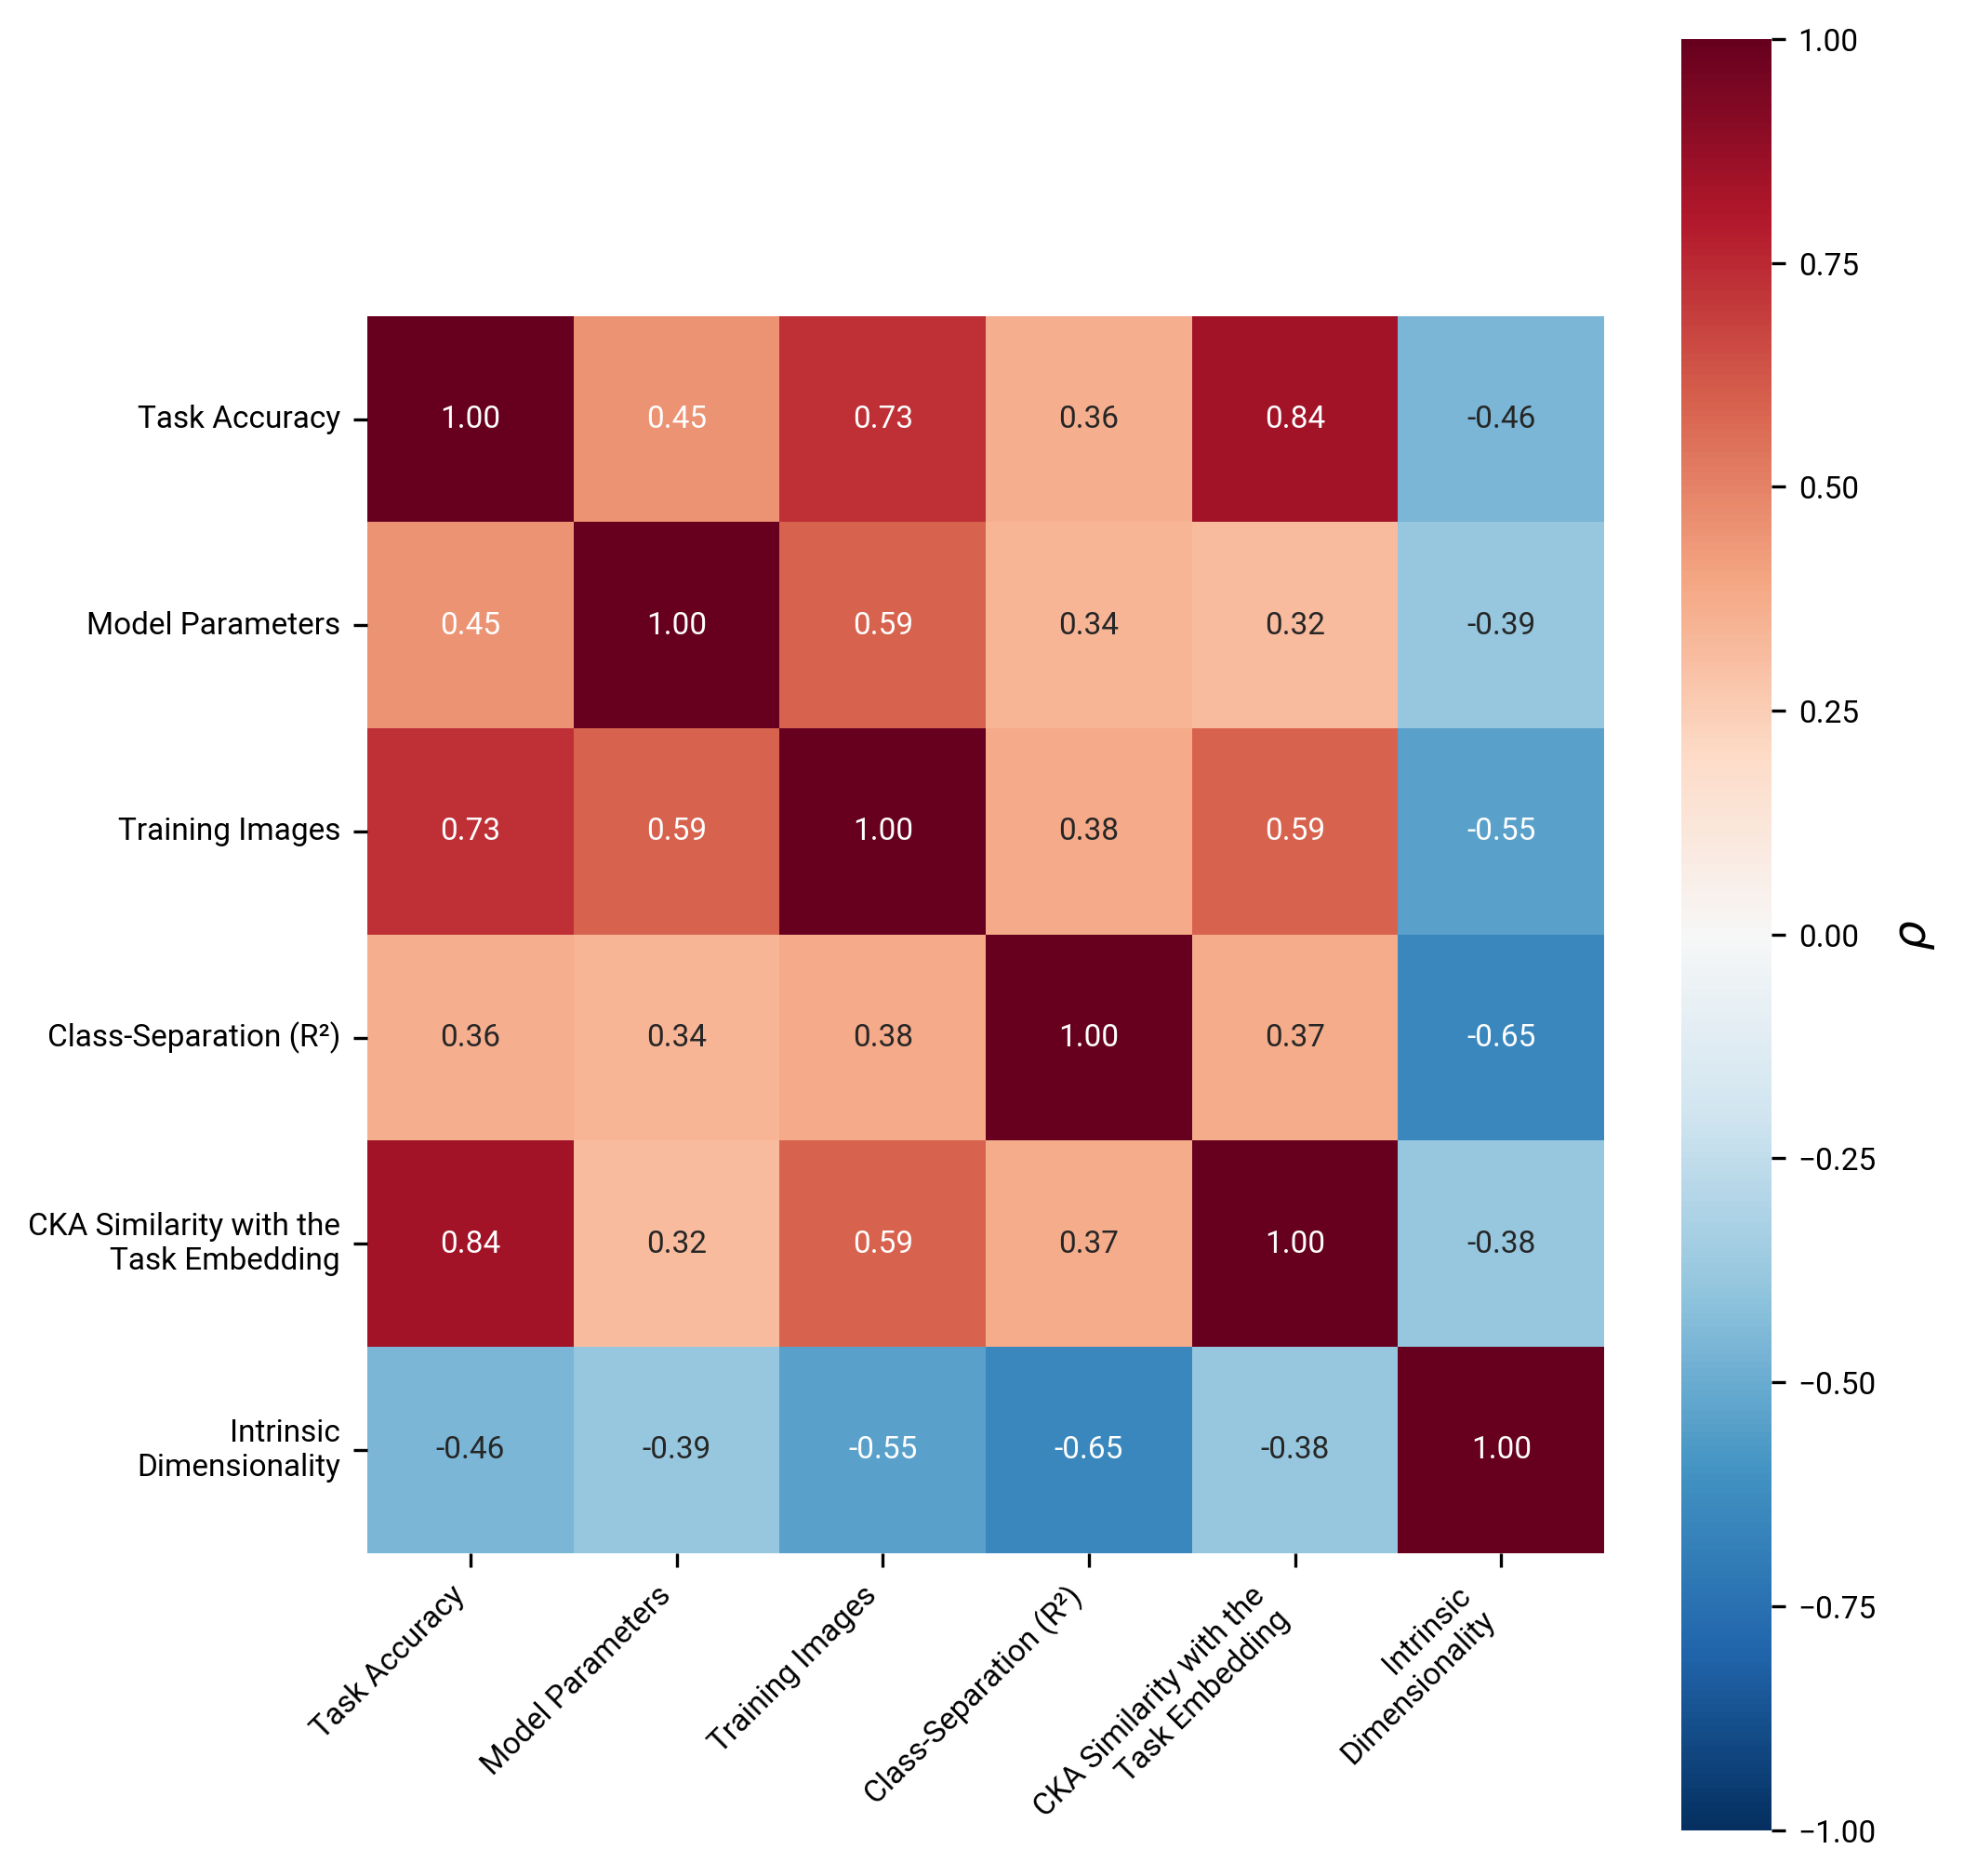

In [5]:
# First merge the additional metrics into merged_df
df_with_metrics = pd.merge(
    merged_df,
    r2_df[['features', 'r2']],
    on='features',
    how='left'
)

df_with_metrics = pd.merge(
    df_with_metrics,
    task_cka_df[['features', 'cka']],
    on='features',
    how='left'
)

df_with_metrics = pd.merge(
    df_with_metrics,
    id_df[['features', 'local ID']],
    on='features',
    how='left'
)

# Select the relevant columns and calculate correlations
cols = [
    'return', 'model_size', 'training_data', 'r2', 'cka', 'local ID'
]
corr_df = df_with_metrics[cols].copy()

# Convert numeric columns, handling any non-numeric values
corr_df['model_size'] = pd.to_numeric(corr_df['model_size'], errors='coerce')
corr_df['training_data'] = pd.to_numeric(corr_df['training_data'], errors='coerce')

# Calculate Spearman correlations
corr_matrix = corr_df.corr(method='spearman')

# Create custom labels
labels = [
    'Task Accuracy',
    'Model Parameters',
    'Training Images',
    'Class-Separation (R²)',
    'CKA Similarity with the\nTask Embedding',
    'Intrinsic\nDimensionality'
]

# Create the heatmap
plt.figure(figsize=(FIGWIDTH, FIGWIDTH))
heatmap = sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    xticklabels=labels,
    yticklabels=labels
)

colorbar = heatmap.collections[0].colorbar
colorbar.set_label(r'$\rho$', rotation=90, size=BIGGER_SIZE)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(join(PROJECT_ROOT, "figures", "pairwise_correlations.pdf"), bbox_inches='tight', dpi=300)
plt.show()
